# Mie single-hole pipeline – debug notebook

Run from project root (`Mie_Postprocessing_Py`). Each section expands a major function into steps with explicit data-flow checks.

In [3]:
# --- Notebook setup and imports ---
# Run this notebook from the project root: Mie_Postprocessing_Py
import sys
from pathlib import Path

ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

import json
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from OSCC_postprocessing.cine.functions_videos import load_cine_video
from OSCC_postprocessing.filters.bilateral_filter import bilateral_filter_video_cpu, bilateral_filter_video_cupy
from OSCC_postprocessing.binary_ops.functions_bw import (
    keep_largest_component_cuda,
    keep_largest_component_nd_cuda,
)
from OSCC_postprocessing.analysis.multihole_utils import (
    resolve_backend,
    compute_cone_angle_from_angular_density,
    triangle_binarize_gpu,
)
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    to_numpy,
    _binary_fill_holes_gpu,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.analysis.hysteresis import detect_single_high_interval, longest_true_run
from OSCC_postprocessing.playback.video_playback import play_videos_side_by_side

# Pick the best available rotation backend (GPU if available, else CPU).
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend

warnings.filterwarnings("ignore", category=RuntimeWarning)
use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")
print("CUDA used:", use_gpu, "| xp:", xp)


CUDA used: True | xp: <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Postprocessing_Py\\.venv\\Lib\\site-packages\\cupy\\__init__.py'>


In [4]:
def _as_numpy(arr):
    """Convert NumPy/CuPy arrays to NumPy for plotting/logging."""
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)


def _array_module(arr):
    """Return cp for CuPy arrays and np for NumPy arrays."""
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp
    return np


def plot_metrics_dataframe(df, title=""):
    """Plot all numeric columns from a metrics DataFrame."""
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if not numeric_cols:
        print("No numeric columns to plot.")
        return

    n_cols = len(numeric_cols)
    n_rows = (n_cols + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(12, 2.5 * n_rows), squeeze=False)
    axes = axes.flatten()

    x = np.arange(len(df))
    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        ax.plot(x, df[col], linewidth=1.0)
        ax.set_title(col, fontsize=9)
        ax.set_xlabel("Frame")
        ax.grid(alpha=0.25)
        ax.tick_params(labelsize=7)

    for j in range(n_cols, len(axes)):
        axes[j].set_visible(False)
    if title == "":
        fig.suptitle("Single-hole Mie metrics", fontsize=12)
    else: 
        fig.suptitle(title, fontsize=12)
    fig.tight_layout()
    plt.show()


## Manual input (same as `main()`)

Set `file`, `json_file`, and `out_dir` for debugging.

In [130]:
# --- Input/output configuration ---
file = Path(r"G:\MeOH_test\Mie\T1_Mie Camera_4.cine")
json_file = Path(r"G:\MeOH_test\Mie\config.json")
out_dir = Path(r"G:\MeOH_test\Mie\Processed_Results")

gain_compensation = False
frame_limit = 200

save_name_stem = file.stem
Path(out_dir / "Rotated_Videos").mkdir(parents=True, exist_ok=True)
Path(out_dir / "Postprocessed_Data").mkdir(parents=True, exist_ok=True)
video_out_dir = out_dir / "Rotated_Videos"
data_out_dir = out_dir / "Postprocessed_Data"

print("file:", file)
print("json_file:", json_file)
print("out_dir:", out_dir)
print("video_out_dir:", video_out_dir)
print("data_out_dir:", data_out_dir)


file: G:\MeOH_test\Mie\T1_Mie Camera_4.cine
json_file: G:\MeOH_test\Mie\config.json
out_dir: G:\MeOH_test\Mie\Processed_Results
video_out_dir: G:\MeOH_test\Mie\Processed_Results\Rotated_Videos
data_out_dir: G:\MeOH_test\Mie\Processed_Results\Postprocessed_Data


## Setup: load video and config (from `main()`)

Load .cine, normalize to [0,1], load JSON (centre, offset, inner/outer radius).

In [131]:
video_bits = 12
brightness_levels = 2.0 ** video_bits
video = load_cine_video(file, frame_limit=frame_limit)
F0, H0, W0 = video.shape
print("Video shape (F,H,W):", video.shape)

if use_gpu:
    video = cp.asarray(video, dtype=cp.float16)
    video *= cp.float16(1.0 / brightness_levels)
else:
    video *= np.float16(1.0 / brightness_levels)

with open(json_file, "r", encoding="utf-8") as f:
    data = json.load(f)
number_of_plumes = int(data["plumes"])
offset = float(data["offset"])
centre = (float(data["centre_x"]), float(data["centre_y"]))
ir_ = float(data["inner_radius"])
or_ = float(data["outer_radius"])

print("centre:", centre, "| offset:", offset, "| ir_:", ir_, "| or_:", or_)

Video Info - Width: 768, Height: 768, Frames: 200
Video shape (F,H,W): (200, 768, 768)
centre: (604.0, 82.0) | offset: -135.0 | ir_: 0.0 | or_: 760.0


---
## Expand: `mie_preprocessing`

Steps: (1) rotation + crop, (2) bilateral filter, (3) background subtraction. Check data flow after each step.

### Step 1: Rotation + crop

In [132]:
video_strip_relative_height = 1.0 / 3
outer_radius = or_
out_h = max(1, int(round(float(video_strip_relative_height) * float(outer_radius))))
out_w = int(round(float(outer_radius)))
OUT_SHAPE = (out_h, out_w)
INTERPOLATION = "nearest"
BORDER_MODE = "constant"

use_gpu_rot = USING_CUPY
if use_gpu_rot:
    try:
        segment, _, _ = rotate_video_nozzle_at_0_half_backend(
            video, centre, offset,
            interpolation=INTERPOLATION, border_mode=BORDER_MODE, out_shape=OUT_SHAPE,
        )
    except Exception as exc:
        print(f"GPU rotation failed ({exc}), falling back to CPU.")
        use_gpu_rot = False
if not use_gpu_rot:
    segment = _rotate_align_video_cpu(
        to_numpy(video), centre, offset,
        interpolation=INTERPOLATION, border_mode=BORDER_MODE, out_shape=OUT_SHAPE, cval=0.0,
    )

print("segment.shape:", segment.shape)
print("segment dtype:", getattr(segment, 'dtype', type(segment)))
print("segment min/max:", _as_numpy(segment).min(), _as_numpy(segment).max())

segment.shape: (200, 253, 760)
segment dtype: float32
segment min/max: 0.0 0.57128906


### Step 2: Bilateral filter

In [133]:
wsize, sigma_d, sigma_r = 7, 3.0, 3.0
if use_gpu_rot:
    bilateral_filtered = bilateral_filter_video_cupy(segment, wsize, sigma_d, sigma_r)
else:
    bilateral_filtered = bilateral_filter_video_cpu(np.asarray(segment), wsize, sigma_d, sigma_r)

print("bilateral_filtered.shape:", bilateral_filtered.shape)
print("bilateral_filtered min/max:", _as_numpy(bilateral_filtered).min(), _as_numpy(bilateral_filtered).max())

bilateral_filtered.shape: (200, 253, 760)
bilateral_filtered min/max: 0.0 0.50146353


### Step 3: Background subtraction

In [134]:
# --- Background subtraction ---
blank_frames = min(max(1, 10), segment.shape[0])
xp_pre = _array_module(bilateral_filtered)

bkg = xp_pre.mean(bilateral_filtered[:blank_frames], axis=0, keepdims=True)
eps = xp_pre.asarray(1e-9, dtype=bkg.dtype)
bkg = xp_pre.where(bkg == 0, eps, bkg)
bkg = xp_pre.where(xp_pre.isnan(bkg), eps, bkg)
foreground = bilateral_filtered - bkg

print("foreground.shape:", foreground.shape)
print("foreground min/max:", _as_numpy(foreground).min(), _as_numpy(foreground).max())

# Preview: aligned strip | foreground | scaled absolute difference
play_videos_side_by_side(
    (
        _as_numpy(segment).swapaxes(1, 2),
        _as_numpy(foreground).swapaxes(1, 2),
        (10.0 * np.abs(_as_numpy(foreground) - _as_numpy(segment))).swapaxes(1, 2),
    ),
    intv=17,
)


foreground.shape: (200, 253, 760)
foreground min/max: -0.03609378 0.4645678


---
## Expand: `mie_single_hole_pipeline` (after preprocessing)

Use `segment`, `foreground` from above. Pipeline steps: nozzle timing → TD map & penetration → cone angle → full solver (optional).

### Pipeline: F, H, W and nozzle timing (hydraulic delay, nozzle closing)

In [135]:
# --- Hydraulic delay / nozzle closing from near-nozzle intensity ---
F, H, W = foreground.shape
near_nozzle_relative_height, near_nozzle_relative_width = 1.0 / 20, 1.0 / 20
xp_fg = _array_module(foreground)

near_nozzle_video_patch = foreground[
    :,
    int(H // 2 - H * near_nozzle_relative_height // 2) : int(H // 2 + H * near_nozzle_relative_height // 2),
    : int(W * near_nozzle_relative_width),
]
near_nozzle_intensity_sums = xp_fg.sum(near_nozzle_video_patch, axis=(1, 2))

y = _min_max_scale(near_nozzle_intensity_sums.T)
res, mask, _ = detect_single_high_interval(y)

if res is None:
    hydraulic_delay = np.nan
    nozzle_closing = np.nan
    hd = np.nan
    nc = np.nan
    Lo_Hi = np.zeros(F, dtype=bool)
else:
    hd, nc, _, _ = res
    hydraulic_delay = float(_as_numpy(hd)) - 1.0
    nozzle_closing = float(_as_numpy(nc))
    hd = hydraulic_delay
    nc = nozzle_closing
    Lo_Hi = np.asarray(_as_numpy(mask), dtype=bool)

print("hydraulic_delay:", hydraulic_delay, "| nozzle_closing:", nozzle_closing)
print("Lo_Hi sum (frames with spray):", Lo_Hi.sum())


hydraulic_delay: nan | nozzle_closing: nan
Lo_Hi sum (frames with spray): 0


### Pipeline: Time–distance map, brightness peak, gain curve, penetration from TD

### Preview: Time–distance intensity heatmap (with hydraulic delay & nozzle closing)

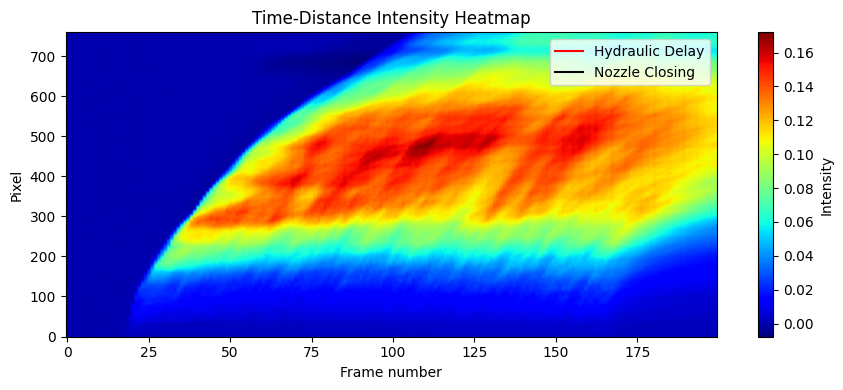

In [136]:
# --- Time-distance (TD) map before gain compensation ---
xp_fg = _array_module(foreground)
td_map_vis = (1.0 / H) * xp_fg.sum(foreground, axis=1).T

plt.figure(figsize=(9, 4))
plt.imshow(_as_numpy(td_map_vis), origin="lower", aspect="auto", cmap="jet")
plt.title("Time-Distance Intensity Heatmap")
plt.colorbar(label="Intensity")
plt.xlabel("Frame number")
plt.ylabel("Pixel")
plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
plt.legend()
plt.tight_layout()
plt.show()


In [137]:
# --- Brightness trend and optional gain compensation ---
xp_fg = _array_module(foreground)
td_map = (1.0 / H) * xp_fg.sum(foreground, axis=1).T
average_pixel_intensity = (1.0 / W) * xp_fg.sum(td_map, axis=0)

brightness_peak = int(_as_numpy(xp_fg.argmax(average_pixel_intensity)).item())
peak_intensity_sum = xp_fg.max(average_pixel_intensity)
ratio = average_pixel_intensity / (peak_intensity_sum + 1e-9)

if gain_compensation:
    gain_curve = 1.0 / (1e-9 + ratio.astype(xp_fg.float64))
    gain_curve[:brightness_peak] = 1.0
else:
    gain_curve = xp_fg.ones_like(ratio)

print("td_map.shape:", td_map.shape, "| brightness_peak:", brightness_peak)


td_map.shape: (760, 200) | brightness_peak: 139


### Preview: Frame intensity ratio and gain curve

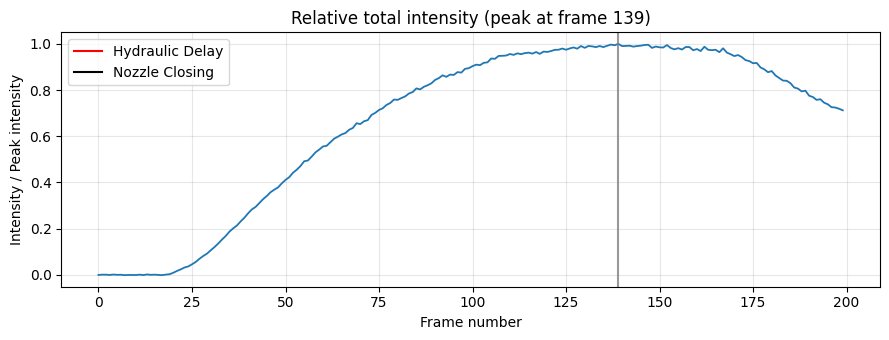

In [138]:
# Ratio of each frame intensity to the peak frame
plt.figure(figsize=(9, 3.5))
plt.plot(_as_numpy(ratio), linewidth=1.3)
plt.grid(alpha=0.3)
plt.axvline(brightness_peak, color="gray", alpha=0.8)
plt.title(f"Relative total intensity (peak at frame {brightness_peak})")
plt.ylabel("Intensity / Peak intensity")
plt.xlabel("Frame number")
plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
plt.legend()
plt.tight_layout()
plt.show()


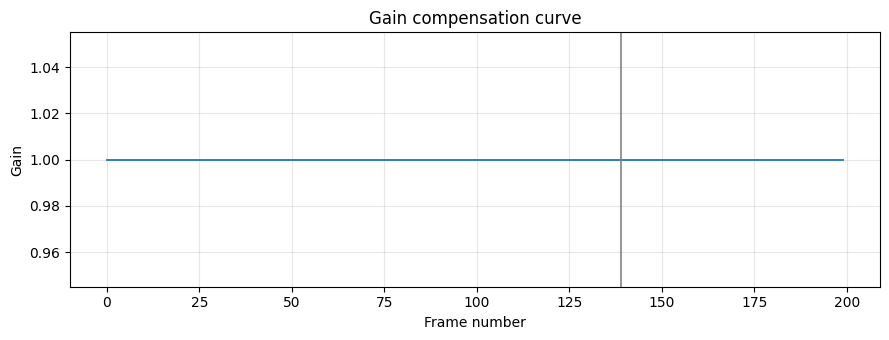

In [139]:
# Gain compensation curve (flat at 1.0 when gain_compensation=False)
plt.figure(figsize=(9, 3.5))
plt.plot(_as_numpy(gain_curve), linewidth=1.3)
plt.axvline(brightness_peak, color="gray", alpha=0.8)
plt.title("Gain compensation curve")
plt.grid(alpha=0.3)
plt.xlabel("Frame number")
plt.ylabel("Gain")
plt.tight_layout()
plt.show()


In [140]:
# --- Penetration from the TD map ---
bw_td = keep_largest_component_cuda(triangle_binarize_gpu(_min_max_scale(td_map)), connectivity=2)
xp_td = _array_module(bw_td)

penetration_TD = bw_td.shape[0] - xp_td.argmax(bw_td[::-1, :], axis=0)
penetration_TD = penetration_TD.astype(xp_td.float32)
penetration_TD[penetration_TD == bw_td.shape[0]] = xp_td.nan

valid_mask = ~xp_td.isnan(penetration_TD)
start, end = longest_true_run(_as_numpy(valid_mask))
penetration_TD[:start] = 0.0
penetration_TD[end:] = xp_td.nan

print("penetration_TD (first/last valid):", start, end)
print("penetration_TD sample:", _as_numpy(penetration_TD)[:5])


penetration_TD (first/last valid): 17 106
penetration_TD sample: [0. 0. 0. 0. 0.]


### Preview: Penetration extracted from time–distance heatmap

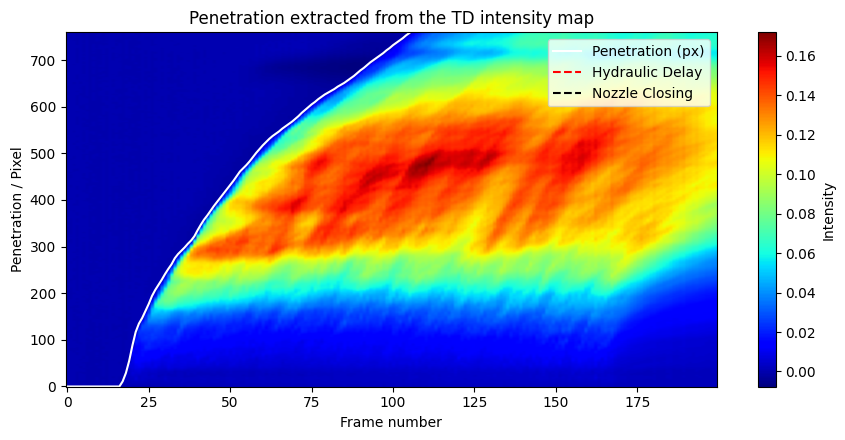

In [141]:
# Overlay penetration trace on top of TD map
plt.figure(figsize=(9, 4.5))
plt.imshow(_as_numpy(td_map), origin="lower", aspect="auto", cmap="jet")
plt.plot(_as_numpy(penetration_TD), color="w", linewidth=1.5, label="Penetration (px)")
plt.title("Penetration extracted from the TD intensity map")
plt.xlabel("Frame number")
plt.ylabel("Penetration / Pixel")
plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r", linestyle="--")
plt.axvline(nozzle_closing, label="Nozzle Closing", color="k", linestyle="--")
plt.legend()
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()


### Pipeline: Cone angle from angular density

In [142]:
accuracy = 0.1
n_bins = int(360.0 / accuracy)
_, signal, _ = angle_signal_density_auto(foreground, 0.0, H // 2, N_bins=n_bins)
AngularDensity = compute_cone_angle_from_angular_density(signal, 0, 2, bins=n_bins, use_gpu=use_gpu)
cone_angle_AD_up = AngularDensity[0]
cone_angle_AD_down = AngularDensity[1]
cone_angle_AD = cone_angle_AD_up + cone_angle_AD_down

print("cone_angle_AD shape:", _as_numpy(cone_angle_AD).shape)
print("cone_angle_AD sample:", _as_numpy(cone_angle_AD)[:5])

cone_angle_AD shape: (200,)
cone_angle_AD sample: [0. 0. 0. 0. 0.]


### Preview: Cone angle from angular density

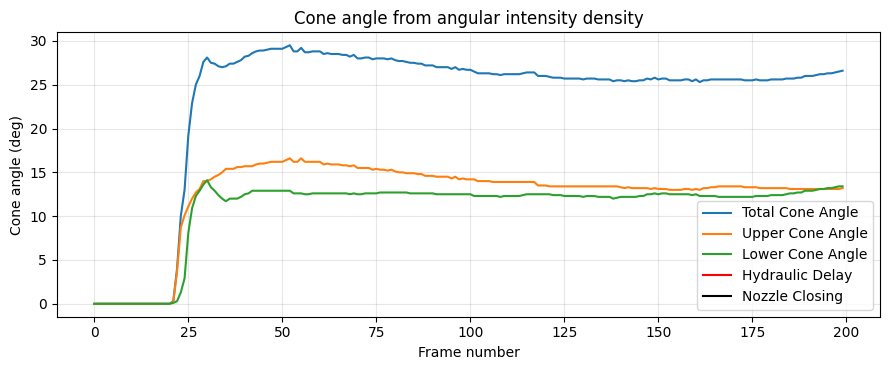

In [143]:
# Cone-angle signals from angular density
plt.figure(figsize=(9, 3.8))
plt.plot(_as_numpy(cone_angle_AD), label="Total Cone Angle")
plt.plot(_as_numpy(cone_angle_AD_down), label="Upper Cone Angle")
plt.plot(_as_numpy(cone_angle_AD_up), label="Lower Cone Angle")
plt.grid(alpha=0.3)
plt.title("Cone angle from angular intensity density")
plt.axvline(hydraulic_delay, label="Hydraulic Delay", color="r")
plt.axvline(nozzle_closing, label="Nozzle Closing", color="k")
plt.legend()
plt.xlabel("Frame number")
plt.ylabel("Cone angle (deg)")
plt.tight_layout()
plt.show()


### Full solver: gain-correct foreground and binarize → `bw_video`

In [144]:
# --- Frame-wise binarization and cleanup ---
foreground_gain = foreground.copy()
xp_fg = _array_module(foreground_gain)

if gain_compensation:
    foreground_gain[int(brightness_peak):] *= xp_fg.asarray(gain_curve[int(brightness_peak):, None, None])

bw_video_0 = triangle_binarize_gpu(foreground_gain)
bw_video_1 = keep_largest_component_nd_cuda(bw_video_0, connectivity=2)
bw_video = _binary_fill_holes_gpu(bw_video_1, mode="2D")

print("bw_video.shape:", bw_video.shape)
print("bw_video sum per frame (sample):", _as_numpy(bw_video.sum(axis=(1, 2)))[:5])


bw_video.shape: (200, 253, 760)
bw_video sum per frame (sample): [0 0 0 0 0]


### Region properties (MATLAB `regionprops` equivalent)

Analyze connected components in the 3D binary to check filtering quality: volume, center of mass, bounding box. Compare all blobs before "keep largest" to see if the largest is the spray or a noise cluster.

In [145]:
from OSCC_postprocessing.binary_ops.functions_bw import regionprops_3d, reconstruct_blob

# Same connectivity as keep_largest_component_nd_cuda (e.g. 2 for 18-neighbors in 3D)
rp_0 = regionprops_3d(bw_video_0, connectivity=2, as_dataframe=True, centroid="True")
# rp_1 = regionprops_3d(bw_video_1, connectivity=2, as_dataframe=True)

print("After binarization (bw_video_0): number of connected regions =", len(rp_0))
print(rp_0.sort_values("volume", ascending=False).to_string())
# print("\nAfter keep-largest-3D-blob (bw_video_1): number of regions =", len(rp_1))
# print(rp_1.sort_values("volume", ascending=False).to_string())

After binarization (bw_video_0): number of connected regions = 32
    label      volume  centroid_0  centroid_1  centroid_2
0       1  15998533.0  128.898260  121.706897  445.990708
1       2     27616.0  116.017164  195.385718   74.456692
24     25       636.0  192.305031  127.558176    3.904088
16     17        41.0  162.000000  182.560976   32.073171
30     31        40.0  193.250000  181.650000   30.900000
31     32        36.0  197.972222  181.444444   31.416667
26     27        36.0  184.194444  182.055556   32.388889
6       7        35.0  117.114286  183.200000   32.085714
25     26        33.0  180.181818  182.242424   32.484848
13     14        33.0  157.151515  182.060606   31.515152
22     23        32.0  176.625000  127.281250    2.718750
19     20        26.0  167.076923  181.923077   31.923077
27     28        25.0  188.760000  182.000000   33.240000
20     21        23.0  171.304348  181.782609   32.130435
11     12        22.0  151.954545  182.636364   32.272727
21    

In [146]:
# Fast: only volumes (default)
# rp = regionprops_3d(bw_video_0, connectivity=2)

# With centroid and bbox
# rp = regionprops_3d(bw_video_0, connectivity=2, volume=True, centroid=True, bbox=True)

# Get label image to reconstruct blobs
props, labels = regionprops_3d(bw_video_0, connectivity=2, return_labels=True, centroid=True)


In [147]:
props["y-dist"] = np.abs(props["centroid_1"] - bw_video.shape[1]//2)
# print(props.sort_values("y-dist", ascending=True).to_string())

threshold = 50
filtered_props = props[props["y-dist"] <= threshold]

filtered_props = filtered_props.sort_values("volume", ascending=False)
print(filtered_props.to_string())

    label      volume  centroid_0  centroid_1  centroid_2     y-dist
0       1  15998533.0  128.898260  121.706897  445.990708   4.293103
24     25       636.0  192.305031  127.558176    3.904088   1.558176
22     23        32.0  176.625000  127.281250    2.718750   1.281250
5       6         1.0  109.000000  171.000000  711.000000  45.000000


In [148]:
# Get the value from the "label" column of the first row (at position 0)
label_id = filtered_props.iloc[0]["label"]

# Or, to get the entire first row as a pandas Series:
largest_blob_row = filtered_props.iloc[0]
print(largest_blob_row)

label         1.000000e+00
volume        1.599853e+07
centroid_0    1.288983e+02
centroid_1    1.217069e+02
centroid_2    4.459907e+02
y-dist        4.293103e+00
Name: 0, dtype: float64


In [149]:
largest_blob = reconstruct_blob(labels, label_id)

for f in range(F):
    largest_blob[f] = keep_largest_component_cuda(largest_blob[f])

bw_video = _binary_fill_holes_gpu(largest_blob, mode="2D")  # or (labels == label_id)

In [150]:
# Visual check: grayscale plume, raw BW, filtered BW
play_videos_side_by_side(
    (
        _as_numpy(foreground_gain).swapaxes(1, 2),
        (255.0 * _as_numpy(bw_video_0)).swapaxes(1, 2),
        (255.0 * _as_numpy(bw_video)).swapaxes(1, 2),
    )
)


### Preview: Foreground before vs after gain correction

In [151]:
# Visual check for gain compensation effect
play_videos_side_by_side(
    (
        _as_numpy(foreground).swapaxes(1, 2),
        _as_numpy(foreground_gain).swapaxes(1, 2),
        np.abs(_as_numpy(foreground_gain) - _as_numpy(foreground)).swapaxes(1, 2),
    ),
    intv=17,
)


---
## Expand: `_compute_full_solver_metrics_from_bw`

Input: `bw_video`, `H`, `F`, `umbrella_angle`. Steps: (1) area, penetration_bw_x, boundary; (2) volumes, penetration_bw_polar; (3) cone angles (avg/lr), build dict.

### Step 1: Column sum, area, penetration_bw_x, boundary

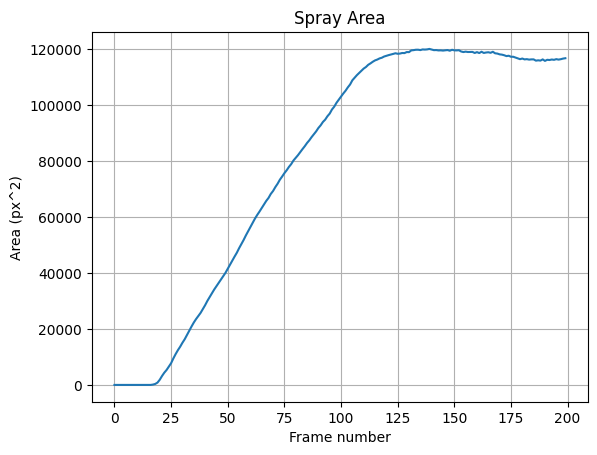

In [152]:
from OSCC_postprocessing.playback.video_playback import play_video_cv2
umbrella_angle = 180.0
bw_video_col_sum = bw_video.sum(axis=1)
area = bw_video_col_sum.sum(axis=-1)

# plt.imshow(_as_numpy(bw_video_col_sum))
plt.title("Spray Area")
plt.xlabel("Frame number")
plt.ylabel("Area (px^2)")
plt.grid()

plt.plot(_as_numpy(area))


In [153]:
play_video_cv2(_as_numpy(255.0*bw_video))


In [154]:
penetration_bw_x = penetration_bw_to_index(bw_video_col_sum > 0)
boundary = bw_boundaries_all_points_single_plume(bw_video, parallel=True, umbrella_angle=180.0)

print("area.shape:", area.shape if hasattr(area, 'shape') else 'scalar')
print("area (sample):", _as_numpy(area)[:5])
pen_x_np = penetration_bw_x.get() if hasattr(penetration_bw_x, 'get') else np.asarray(penetration_bw_x)
print("penetration_bw_x (sample):", pen_x_np[:5])
print("boundary length (frames):", len(boundary))

area.shape: (200,)
area (sample): [0 0 0 0 0]
penetration_bw_x (sample): [-1 -1 -1 -1 -1]
boundary length (frames): 200


### Step 2: x_scale, upper/lower widths, volumes, penetration_bw_polar

In [155]:
if umbrella_angle == 180.0:
    x_scale = 1.0
else:
    tilt_angle = (180.0 - umbrella_angle) / 2.0
    x_scale = 1.0 / np.cos(np.deg2rad(tilt_angle))

upper_bw_width = _as_numpy(bw_video[:, : H // 2, :].sum(axis=1))
lower_bw_width = _as_numpy(bw_video[:, H // 2 :, :].sum(axis=1))
estimated_volume = x_scale * np.pi * 0.25 * np.sum((upper_bw_width + lower_bw_width) ** 2, axis=1)
max_plume_radius = np.maximum(upper_bw_width, lower_bw_width)
min_plume_radius = np.minimum(upper_bw_width, lower_bw_width)
estimated_volume_max = np.pi * x_scale * np.sum(max_plume_radius ** 2, axis=1)
estimated_volume_min = np.pi * x_scale * np.sum(min_plume_radius ** 2, axis=1)

penetration_bw_polar = np.zeros(F)
for i in range(F):
    pts = boundary[i]
    if len(pts[0]) > 0 and len(pts[1]) > 0:
        uy, ux = pts[1][:, 0], pts[1][:, 1]
        ly, lx = pts[0][:, 0], pts[0][:, 1]
        max_r_upper = np.max(np.sqrt(uy ** 2 + ux ** 2))
        max_r_lower = np.max(np.sqrt(ly ** 2 + lx ** 2))
        penetration_bw_polar[i] = max(max_r_upper, max_r_lower)

print("estimated_volume (sample):", estimated_volume[:5])
print("penetration_bw_polar (sample):", penetration_bw_polar[:5])

estimated_volume (sample): [0. 0. 0. 0. 0.]
penetration_bw_polar (sample): [0. 0. 0. 0. 0.]


### Step 3: points_all_frames, cone angles (avg, linear regression), build full_metrics

### Preview: Penetration algorithm comparison

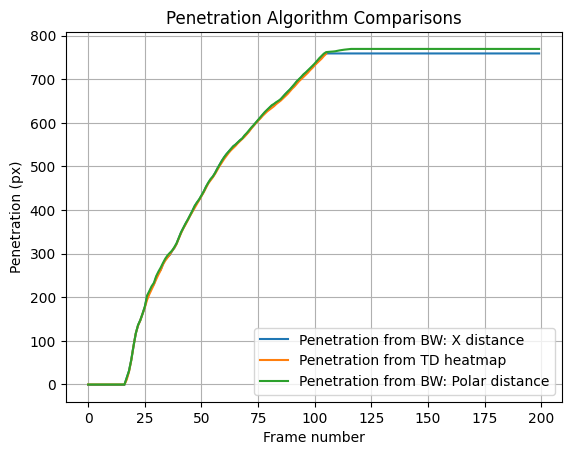

In [156]:
plt.plot(_as_numpy(penetration_bw_x), label="Penetration from BW: X distance")
plt.plot(_as_numpy(penetration_TD), label="Penetration from TD heatmap")
plt.plot(penetration_bw_polar, label="Penetration from BW: Polar distance")
plt.title("Penetration Algorithm Comparisons")
plt.xlabel("Frame number")
plt.ylabel("Penetration (px)")
plt.grid()
plt.legend()
plt.show()

In [157]:
pen_x_for_filter = penetration_bw_x.get() if hasattr(penetration_bw_x, 'get') else np.asarray(penetration_bw_x)
points_all_frames = bw_boundaries_xband_filter_single_plume(boundary, pen_x_for_filter)

lg_up = np.full(F, np.nan)
lg_low = np.full(F, np.nan)
avg_up = np.full(F, np.nan)
avg_low = np.full(F, np.nan)

for i in range(F):
    points = points_all_frames[i]
    if len(points[0]) > 0 and len(points[1]) > 0:
        uy, ux = points[1][:, 0], points[1][:, 1]
        ly, lx = points[0][:, 0], points[0][:, 1]
        ang_up = np.atan(uy / (ux + 1e-9)) * 180.0 / np.pi
        ang_low = np.atan(ly / (lx + 1e-9)) * 180.0 / np.pi
        avg_up[i] = np.nanmean(ang_up)
        avg_low[i] = np.nanmean(ang_low)
        try:
            lg_up[i] = np.atan(linear_regression_fixed_intercept(ux, uy, 0.0)) * 180.0 / np.pi
            lg_low[i] = np.atan(linear_regression_fixed_intercept(lx, ly, 0.0)) * 180.0 / np.pi
        except ValueError:
            pass

cone_angle_average = avg_up - avg_low
cone_angle_linear_regression = lg_up - lg_low

full_metrics = {
    "area": area,
    "penetration_bw_x": penetration_bw_x,
    "boundary": boundary,
    "estimated_volume": estimated_volume,
    "estimated_volume_max": estimated_volume_max,
    "estimated_volume_min": estimated_volume_min,
    "penetration_bw_polar": penetration_bw_polar,
    "cone_angle_average": cone_angle_average,
    "avg_up": avg_up,
    "avg_low": avg_low,
    "cone_angle_linear_regression": cone_angle_linear_regression,
    "lg_up": lg_up,
    "lg_low": lg_low,
}
print("cone_angle_average (sample):", cone_angle_average[:5])
print("cone_angle_linear_regression (sample):", cone_angle_linear_regression[:5])

cone_angle_average (sample): [nan nan nan nan nan]
cone_angle_linear_regression (sample): [nan nan nan nan nan]


### Build DataFrame and save (same columns as pipeline)

---\n## Plot each column in the final DataFrame\n\nPlot every column of `df` vs frame index for quick inspection.

In [158]:
# --- Export metrics to DataFrame/CSV ---
file_name = save_name_stem
df = pd.DataFrame()

df["Penetration_from_TD"] = _as_numpy(penetration_TD)
df["Cone_Angle_Angular_Density"] = _as_numpy(cone_angle_AD)
df["Cone_Angle_Angular_Density_Upper"] = _as_numpy(cone_angle_AD_up)
df["Cone_Angle_Angular_Density_Lower"] = _as_numpy(cone_angle_AD_down)
df["Hydraulic Delay"] = hd
df["Nozzle Closing"] = nc
df["Penetration_from_BW"] = _as_numpy(penetration_bw_x)
df["Penetration_from_BW_Polar"] = full_metrics["penetration_bw_polar"]
df["Area"] = _as_numpy(full_metrics["area"])
df["Estimated_Volume"] = full_metrics["estimated_volume"]
df["Estimated_Volume_Upper_Limit"] = full_metrics["estimated_volume_max"]
df["Estimated_Volume_Lower_Limit"] = full_metrics["estimated_volume_min"]
df["Cone_Angle_Average"] = full_metrics["cone_angle_average"]
df["Cone_Angle_Average_Lower"] = _as_numpy(cone_angle_AD_down)
df["Cone_Angle_Average_Upper"] = _as_numpy(cone_angle_AD_up)
df["Cone_Angle_Linear_Regression"] = full_metrics["cone_angle_linear_regression"]
df["Cone_Angle_Linear_Regression_Lower"] = full_metrics["lg_low"]
df["Cone_Angle_Linear_Regression_Upper"] = full_metrics["lg_up"]

out_csv = data_out_dir / f"{file_name}_metrics.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: G:\MeOH_test\Mie\Processed_Results\Postprocessed_Data\T1_Mie Camera_4_metrics.csv


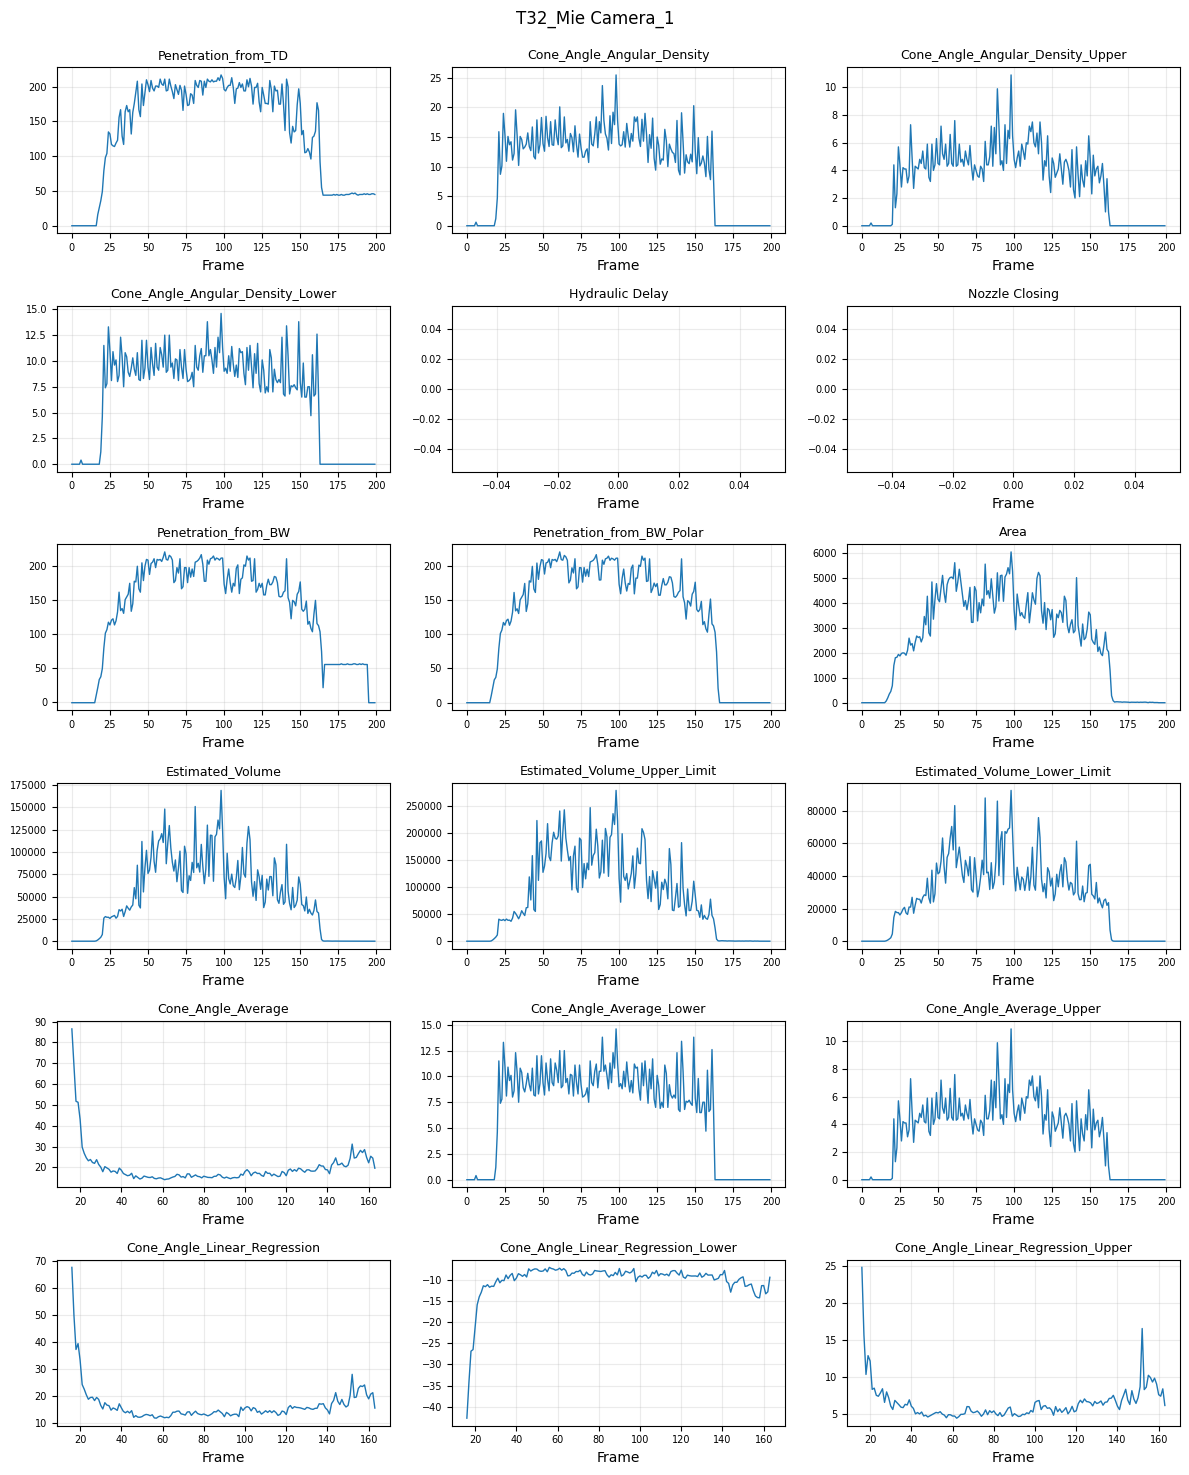

In [128]:
# Plot all numeric metrics after the DataFrame is populated
plot_metrics_dataframe(df, title=file_name+"\n")

# Optional: save boundary CSV
# from concurrent.futures import ThreadPoolExecutor
# executor = ThreadPoolExecutor(max_workers=4)
# save_boundary_csv(boundary, data_out_dir / f"{file_name}_boundary_points.csv", executor=executor)
# executor.shutdown(wait=True)


---
## Optional: run full pipeline in one go (from script)

For comparison, call the script’s `mie_single_hole_pipeline` and optionally `mie_preprocessing` with the same inputs.

In [129]:
# Uncomment to run the script pipeline (ensures same results as mie_single_hole.py main())
# import mie_single_hole as msh
# df_script = msh.mie_single_hole_pipeline(
#     video, save_name_stem, centre, offset, ir_, or_,
#     video_out_dir, data_out_dir,
#     blank_frames=10, umbrella_angle=180.0, save_video_strip=False, preview=False
# )
# print(df_script.head())